<a href="https://colab.research.google.com/github/Sushan9706/Concepts_and_Technologies_of_AI_Final_Assignment/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Task: Beijing PM2.5 Air Quality Analysis
#
# **Course:** 5CS037 Final Portfolio Project  
# **Task:** 3.2 Regression Task  
# **Total Marks:** 100

# ## 1. Exploratory Data Analysis and Data Understanding [20 marks]
#
# ### 1.1 Dataset Selection and Description

# **Dataset Name:** Beijing PM2.5 Data  
# **Source:** UCI Machine Learning Repository  
# **URL:** https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data
#
# **When and by whom:**
# - Created by: Song Xi Chen, School of Mathematical Sciences, Peking University
# - Period: January 1, 2010 to December 31, 2014
# - Data collected from: US Embassy in Beijing and Beijing Municipal Environmental Monitoring Center
#
# **How and from where accessed:**
# - The dataset was accessed from the UCI Machine Learning Repository
# - Data represents hourly measurements of air quality and meteorological parameters
#
# **Alignment with UN Sustainable Development Goal:**
# - **SDG 11:** Sustainable Cities and Communities
# - **Target 11.6:** By 2030, reduce the adverse per capita environmental impact of cities
#
# **Dataset Attributes:** 13 columns including temporal, meteorological, and target PM2.5 features


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
import time

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [69]:
#Load the dataset
df = pd.read_csv('/content/drive/MyDrive/FinalAssignment/PRSA_data_2010.1.1-2014.12.31.csv')

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Dataset Shape: {df.shape}")
print(f"Number of rows: {df.shape[0]:,}")
print(f"Number of columns: {df.shape[1]}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData Types:")
print(df.dtypes)
print("\nBasic Statistics:")
print(df.describe())

DATASET OVERVIEW
Dataset Shape: (43824, 13)
Number of rows: 43,824
Number of columns: 13

First 5 rows:
   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0

Data Types:
No         int64
year       int64
month      int64
day        int64
hour       int64
pm2.5    float64
DEWP       int64
TEMP     float64
PRES     float64
cbwd      object
Iws      float64
Is         int64
Ir         int64
dtype: object

Basic Statistics:
                 No          year         month           day          hour  \
count  43824.000000  43824.000000  43824.000000  43824.000000  43824.000000   
mean   21

In [70]:
# 3. DATA QUALITY ASSESSMENT

print("\n" + "=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)

print("\n1. MISSING VALUES ANALYSIS")
print("-" * 80)
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percentage': missing_pct
})
print(missing_df[missing_df['Missing_Count'] > 0])

print("\n2. DUPLICATE ROWS")
print("-" * 80)
print(f"Number of duplicate rows: {df.duplicated().sum()}")

print("\n3. UNIQUE VALUES PER COLUMN")
print("-" * 80)
for col in df.columns:
    print(f"{col:10s}: {df[col].nunique():6d} unique values")

print("\n4. WIND DIRECTION CATEGORIES")
print("-" * 80)
print(df['cbwd'].value_counts())


DATA QUALITY ASSESSMENT

1. MISSING VALUES ANALYSIS
--------------------------------------------------------------------------------
       Missing_Count  Missing_Percentage
pm2.5           2067            4.716594

2. DUPLICATE ROWS
--------------------------------------------------------------------------------
Number of duplicate rows: 0

3. UNIQUE VALUES PER COLUMN
--------------------------------------------------------------------------------
No        :  43824 unique values
year      :      5 unique values
month     :     12 unique values
day       :     31 unique values
hour      :     24 unique values
pm2.5     :    581 unique values
DEWP      :     69 unique values
TEMP      :     64 unique values
PRES      :     60 unique values
cbwd      :      4 unique values
Iws       :   2788 unique values
Is        :     28 unique values
Ir        :     37 unique values

4. WIND DIRECTION CATEGORIES
--------------------------------------------------------------------------------
cbwd
S

In [71]:
# 4. DATA PREPROCESSING

print("\n" + "=" * 80)
print("DATA PREPROCESSING")
print("=" * 80)

# Create a copy for preprocessing
df_processed = df.copy()

# Remove rows with missing PM2.5 values (target variable)
print(f"\nRows before removing missing PM2.5: {len(df_processed):,}")
df_processed = df_processed.dropna(subset=['pm2.5'])
print(f"Rows after removing missing PM2.5:  {len(df_processed):,}")
print(f"Removed: {len(df) - len(df_processed):,} rows ({(len(df) - len(df_processed))/len(df)*100:.2f}%)")

# Encode categorical variable (wind direction)
le = LabelEncoder()
df_processed['cbwd_encoded'] = le.fit_transform(df_processed['cbwd'])
print(f"\nWind direction encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Create additional temporal features
# Season: 1=Winter, 2=Spring, 3=Summer, 4=Fall
df_processed['season'] = df_processed['month'].apply(
    lambda x: 1 if x in [12, 1, 2] else 2 if x in [3, 4, 5] else 3 if x in [6, 7, 8] else 4
)

# Weekend indicator
df_processed['is_weekend'] = df_processed.apply(
    lambda row: 1 if pd.Timestamp(year=int(row['year']), month=int(row['month']), day=int(row['day'])).dayofweek >= 5 else 0,
    axis=1
)

print("\nNew features created:")
print("  - cbwd_encoded: Label-encoded wind direction")
print("  - season: Seasonal indicator (1-4)")
print("  - is_weekend: Weekend flag (0/1)")
print(f"\nFinal dataset shape: {df_processed.shape}")


DATA PREPROCESSING

Rows before removing missing PM2.5: 43,824
Rows after removing missing PM2.5:  41,757
Removed: 2,067 rows (4.72%)

Wind direction encoding: {'NE': np.int64(0), 'NW': np.int64(1), 'SE': np.int64(2), 'cv': np.int64(3)}

New features created:
  - cbwd_encoded: Label-encoded wind direction
  - season: Seasonal indicator (1-4)
  - is_weekend: Weekend flag (0/1)

Final dataset shape: (41757, 16)



EXPLORATORY DATA ANALYSIS

SUMMARY STATISTICS
--------------------------------------------------------------------------------
              pm2.5          DEWP          TEMP          PRES           Iws  \
count  41757.000000  41757.000000  41757.000000  41757.000000  41757.000000   
mean      98.613215      1.750174     12.401561   1016.442896     23.866747   
std       92.050387     14.433658     12.175215     10.300733     49.617495   
min        0.000000    -40.000000    -19.000000    991.000000      0.450000   
25%       29.000000    -10.000000      2.000000   1008.000000      1.790000   
50%       72.000000      2.000000     14.000000   1016.000000      5.370000   
75%      137.000000     15.000000     23.000000   1025.000000     21.910000   
max      994.000000     28.000000     42.000000   1046.000000    565.490000   

                 Is            Ir  
count  41757.000000  41757.000000  
mean       0.055344      0.194866  
std        0.778875      1.418165  
min        0.000

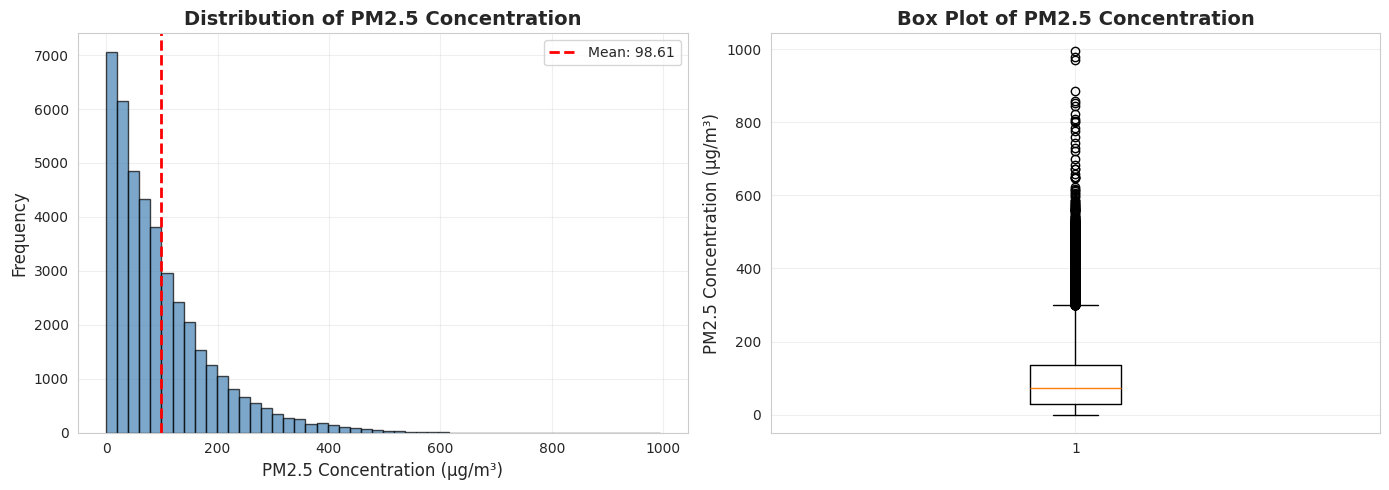


Generating temporal trend plots...
Saved: PM25_temporal_trends.png


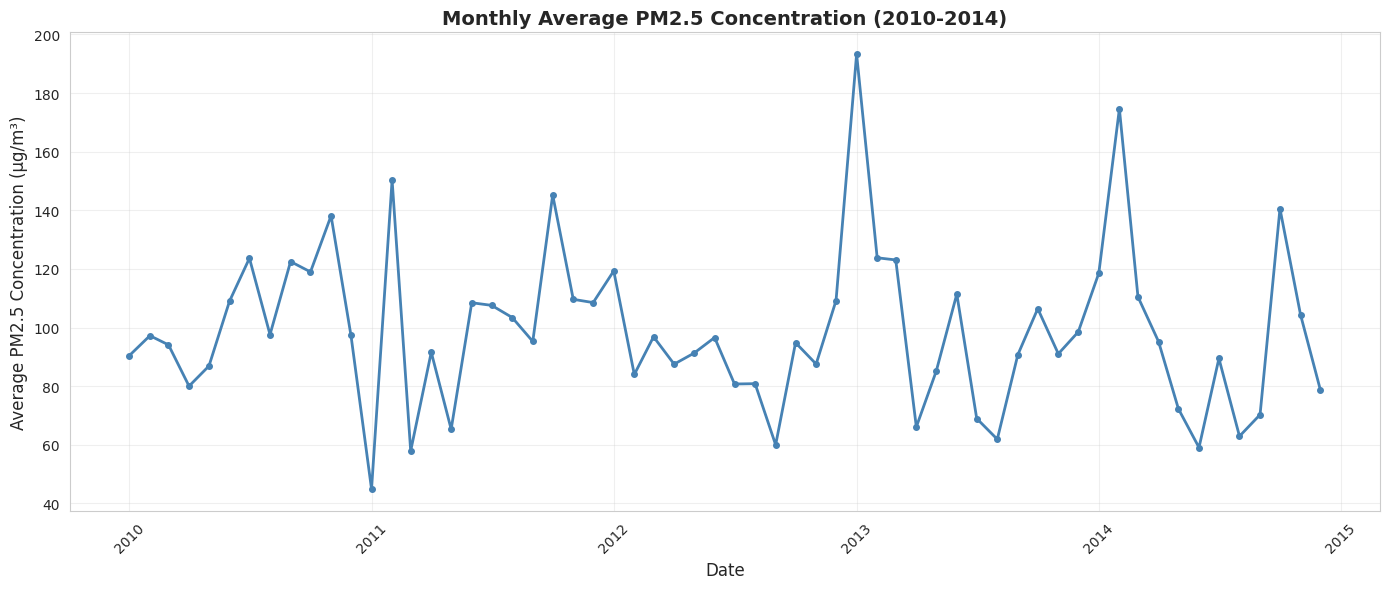


Generating correlation heatmap...
 Saved: PM25_correlation_matrix.png


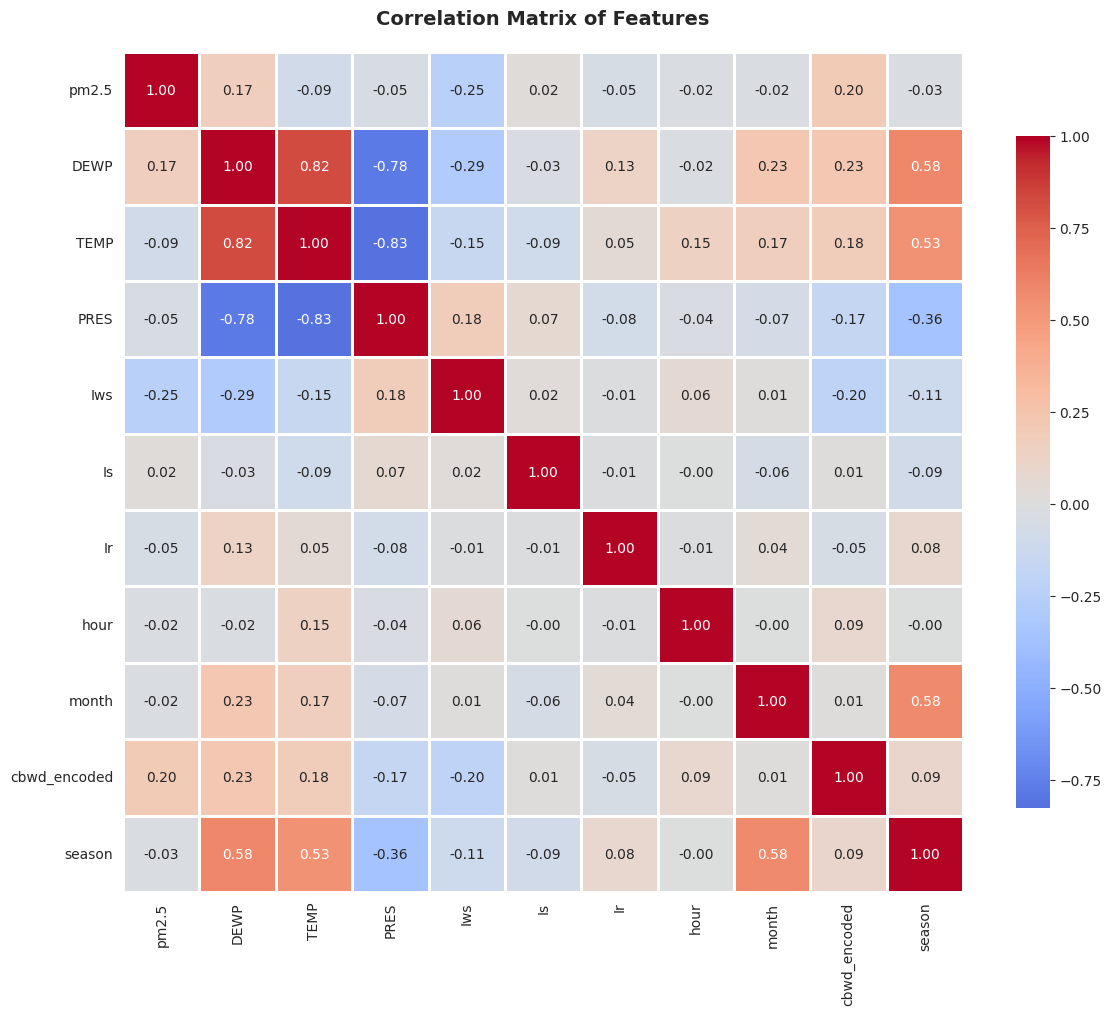

In [72]:
# 5. EXPLORATORY DATA ANALYSIS (EDA)

print("\n" + "=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Summary statistics
print("\nSUMMARY STATISTICS")
print("-" * 80)
print(df_processed[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']].describe())

# Visualization 1: PM2.5 Distribution
print("\nGenerating PM2.5 distribution plots...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_processed['pm2.5'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('PM2.5 Concentration (μg/m³)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of PM2.5 Concentration', fontsize=14, fontweight='bold')
axes[0].axvline(df_processed['pm2.5'].mean(), color='red', linestyle='--',
                linewidth=2, label=f"Mean: {df_processed['pm2.5'].mean():.2f}")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(df_processed['pm2.5'], vert=True)
axes[1].set_ylabel('PM2.5 Concentration (μg/m³)', fontsize=12)
axes[1].set_title('Box Plot of PM2.5 Concentration', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('PM25_distribution.png', dpi=300, bbox_inches='tight')
print(" Saved: PM25_distribution.png")
plt.show()

# Visualization 2: PM2.5 Trends Over Time
print("\nGenerating temporal trend plots...")
df_monthly = df_processed.groupby(['year', 'month'])['pm2.5'].mean().reset_index()
df_monthly['date'] = pd.to_datetime(df_monthly[['year', 'month']].assign(day=1))

plt.figure(figsize=(14, 6))
plt.plot(df_monthly['date'], df_monthly['pm2.5'], marker='o', linewidth=2,
         markersize=4, color='steelblue')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average PM2.5 Concentration (μg/m³)', fontsize=12)
plt.title('Monthly Average PM2.5 Concentration (2010-2014)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('PM25_temporal_trends.png', dpi=300, bbox_inches='tight')
print("Saved: PM25_temporal_trends.png")
plt.show()

# Visualization 3: Correlation Analysis
print("\nGenerating correlation heatmap...")
numerical_features = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir',
                      'hour', 'month', 'cbwd_encoded', 'season']
corr_matrix = df_processed[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('PM25_correlation_matrix.png', dpi=300, bbox_inches='tight')
print(" Saved: PM25_correlation_matrix.png")
plt.show()

In [73]:
# 6. PREPARE DATA FOR MODELING

print("\n" + "=" * 80)
print("DATA PREPARATION FOR MODELING")
print("=" * 80)

# Define features
feature_columns = ['year', 'month', 'day', 'hour', 'DEWP', 'TEMP', 'PRES',
                   'cbwd_encoded', 'Iws', 'Is', 'Ir', 'season', 'is_weekend']

X = df_processed[feature_columns].values
y = df_processed['pm2.5'].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Number of features: {len(feature_columns)}")
print(f"\nFeature list:")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {feat}")


DATA PREPARATION FOR MODELING

Feature matrix shape: (41757, 13)
Target vector shape: (41757,)
Number of features: 13

Feature list:
   1. year
   2. month
   3. day
   4. hour
   5. DEWP
   6. TEMP
   7. PRES
   8. cbwd_encoded
   9. Iws
  10. Is
  11. Ir
  12. season
  13. is_weekend



NEURAL NETWORK MODEL

Data split for Neural Network:
  Training set:    29246 samples (70.0%)
  Validation set:   6247 samples (15.0%)
  Test set:         6264 samples (15.0%)

 Features scaled using StandardScaler

--------------------------------------------------------------------------------
NEURAL NETWORK ARCHITECTURE
--------------------------------------------------------------------------------


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,161 (47.50 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 0 (0.00 B)


Training Neural Network...
(This may take a few minutes...)

Epoch 75: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 95: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 98.
 Training completed in 100 epochs

NEURAL NETWORK PERFORMANCE
Metric          Training        Test           
--------------------------------------------------------------------------------
MAE (μg/m³)     34.73           36.24          
RMSE (μg/m³)    51.87           54.59          
R²              0.6807          0.6562         

Generating training history plot...
Saved: NN_training_history.png


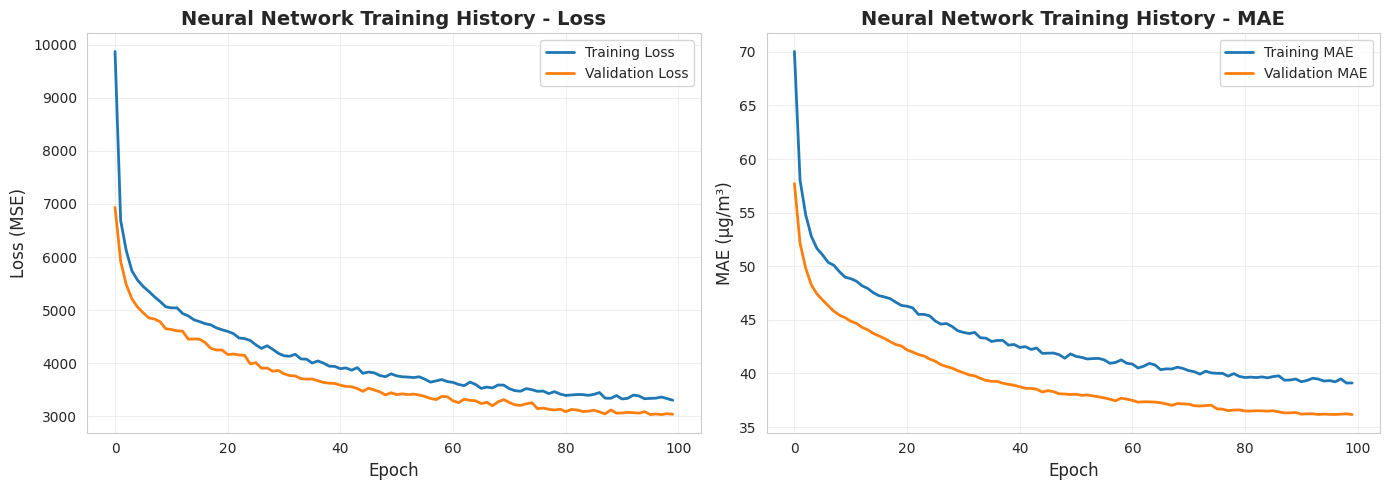


Generating prediction vs actual plot...
 Saved: NN_predicted_vs_actual.png


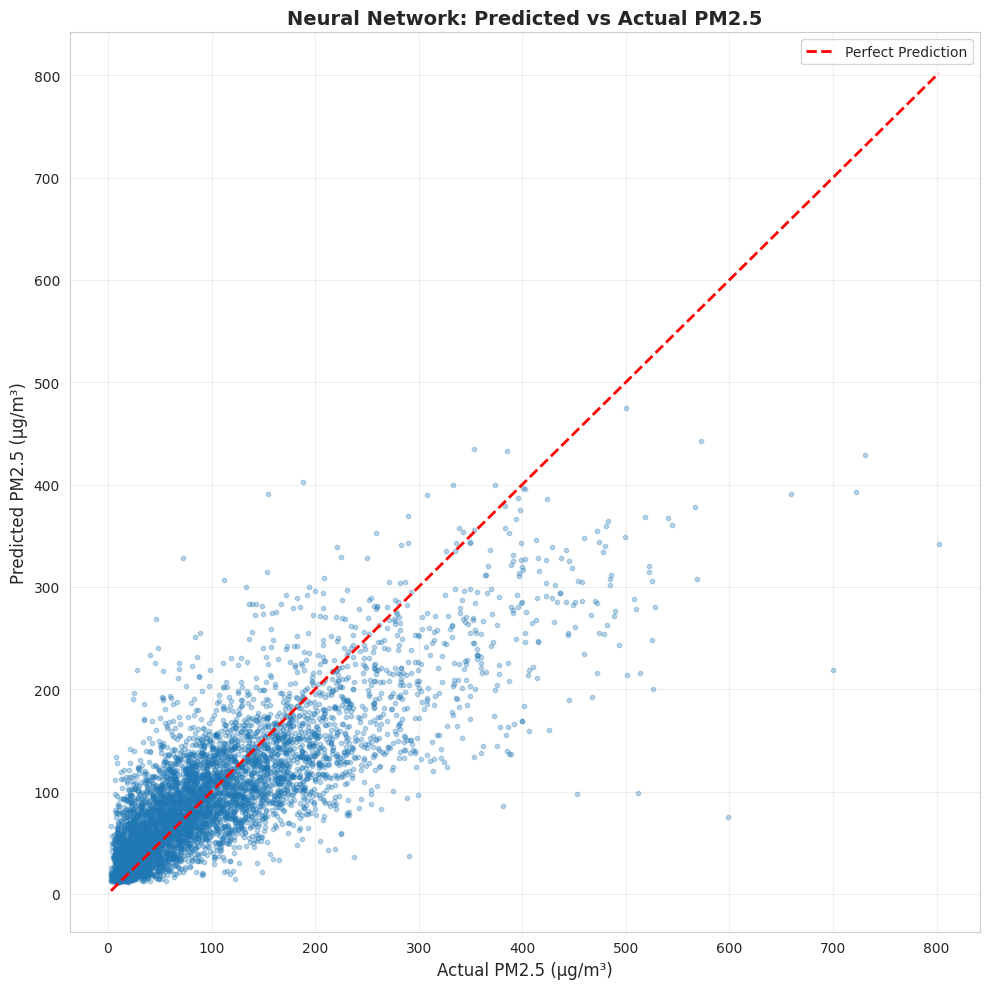

In [74]:
# 7. BUILD NEURAL NETWORK MODEL


print("\n" + "=" * 80)
print("NEURAL NETWORK MODEL")
print("=" * 80)

# Split data: 70% train, 15% validation, 15% test
X_temp, X_test_nn, y_temp, y_test_nn = train_test_split(X, y, test_size=0.15, random_state=42)
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

print(f"\nData split for Neural Network:")
print(f"  Training set:   {X_train_nn.shape[0]:6d} samples ({X_train_nn.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation set: {X_val_nn.shape[0]:6d} samples ({X_val_nn.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set:       {X_test_nn.shape[0]:6d} samples ({X_test_nn.shape[0]/len(X)*100:.1f}%)")

# Feature scaling
scaler_nn = StandardScaler()
X_train_nn_scaled = scaler_nn.fit_transform(X_train_nn)
X_val_nn_scaled = scaler_nn.transform(X_val_nn)
X_test_nn_scaled = scaler_nn.transform(X_test_nn)

print("\n Features scaled using StandardScaler")

# Build Neural Network Model
def create_nn_model(input_dim, learning_rate=0.001):
    """Create deep neural network for regression"""
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='linear')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
    return model

nn_model = create_nn_model(input_dim=X_train_nn_scaled.shape[1])

print("\n" + "-" * 80)
print("NEURAL NETWORK ARCHITECTURE")
print("-" * 80)
nn_model.summary()

# Train the neural network
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True, verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1
)

print("\nTraining Neural Network...")
print("(This may take a few minutes...)")
history = nn_model.fit(
    X_train_nn_scaled, y_train_nn,
    validation_data=(X_val_nn_scaled, y_val_nn),
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

print(f" Training completed in {len(history.history['loss'])} epochs")

# Evaluate neural network
y_train_pred_nn = nn_model.predict(X_train_nn_scaled, verbose=0).flatten()
y_test_pred_nn = nn_model.predict(X_test_nn_scaled, verbose=0).flatten()

train_mae_nn = mean_absolute_error(y_train_nn, y_train_pred_nn)
train_rmse_nn = np.sqrt(mean_squared_error(y_train_nn, y_train_pred_nn))
train_r2_nn = r2_score(y_train_nn, y_train_pred_nn)

test_mae_nn = mean_absolute_error(y_test_nn, y_test_pred_nn)
test_rmse_nn = np.sqrt(mean_squared_error(y_test_nn, y_test_pred_nn))
test_r2_nn = r2_score(y_test_nn, y_test_pred_nn)

print("\n" + "=" * 80)
print("NEURAL NETWORK PERFORMANCE")
print("=" * 80)
print(f"{'Metric':<15} {'Training':<15} {'Test':<15}")
print("-" * 80)
print(f"{'MAE (μg/m³)':<15} {train_mae_nn:<15.2f} {test_mae_nn:<15.2f}")
print(f"{'RMSE (μg/m³)':<15} {train_rmse_nn:<15.2f} {test_rmse_nn:<15.2f}")
print(f"{'R²':<15} {train_r2_nn:<15.4f} {test_r2_nn:<15.4f}")
print("=" * 80)

# Plot training history
print("\nGenerating training history plot...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Neural Network Training History - Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE (μg/m³)', fontsize=12)
axes[1].set_title('Neural Network Training History - MAE', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('NN_training_history.png', dpi=300, bbox_inches='tight')
print("Saved: NN_training_history.png")
plt.show()

# Plot predictions vs actual
print("\nGenerating prediction vs actual plot...")
plt.figure(figsize=(10, 10))
plt.scatter(y_test_nn, y_test_pred_nn, alpha=0.3, s=10)
plt.plot([y_test_nn.min(), y_test_nn.max()], [y_test_nn.min(), y_test_nn.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual PM2.5 (μg/m³)', fontsize=12)
plt.ylabel('Predicted PM2.5 (μg/m³)', fontsize=12)
plt.title('Neural Network: Predicted vs Actual PM2.5', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('NN_predicted_vs_actual.png', dpi=300, bbox_inches='tight')
print(" Saved: NN_predicted_vs_actual.png")
plt.show()



In [75]:
# 8. BUILD CLASSICAL MACHINE LEARNING MODELS

print("\n" + "=" * 80)
print("CLASSICAL MACHINE LEARNING MODELS")
print("=" * 80)

# Prepare data for classical ML models (80-20 split)
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nData split for ML models:")
print(f"  Training set: {X_train_ml.shape[0]:6d} samples ({X_train_ml.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set:     {X_test_ml.shape[0]:6d} samples ({X_test_ml.shape[0]/len(X)*100:.1f}%)")

# Model 1: Random Forest
print("\n" + "-" * 80)
print("Training Random Forest Regressor (initial)...")
print("-" * 80)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_ml, y_train_ml)

y_train_pred_rf = rf_model.predict(X_train_ml)
y_test_pred_rf = rf_model.predict(X_test_ml)

train_mae_rf = mean_absolute_error(y_train_ml, y_train_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train_ml, y_train_pred_rf))
train_r2_rf = r2_score(y_train_ml, y_train_pred_rf)

test_mae_rf = mean_absolute_error(y_test_ml, y_test_pred_rf)
test_rmse_rf = np.sqrt(mean_squared_error(y_test_ml, y_test_pred_rf))
test_r2_rf = r2_score(y_test_ml, y_test_pred_rf)

print(f" Random Forest (initial) trained")
print(f"  Training - MAE: {train_mae_rf:.2f}, RMSE: {train_rmse_rf:.2f}, R²: {train_r2_rf:.4f}")
print(f"  Test     - MAE: {test_mae_rf:.2f}, RMSE: {test_rmse_rf:.2f}, R²: {test_r2_rf:.4f}")

# Model 2: Gradient Boosting
print("\n" + "-" * 80)
print("Training Gradient Boosting Regressor (initial)...")
print("-" * 80)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_ml, y_train_ml)

y_train_pred_gb = gb_model.predict(X_train_ml)
y_test_pred_gb = gb_model.predict(X_test_ml)

train_mae_gb = mean_absolute_error(y_train_ml, y_train_pred_gb)
train_rmse_gb = np.sqrt(mean_squared_error(y_train_ml, y_train_pred_gb))
train_r2_gb = r2_score(y_train_ml, y_train_pred_gb)

test_mae_gb = mean_absolute_error(y_test_ml, y_test_pred_gb)
test_rmse_gb = np.sqrt(mean_squared_error(y_test_ml, y_test_pred_gb))
test_r2_gb = r2_score(y_test_ml, y_test_pred_gb)

print(f" Gradient Boosting (initial) trained")
print(f"  Training - MAE: {train_mae_gb:.2f}, RMSE: {train_rmse_gb:.2f}, R²: {train_r2_gb:.4f}")
print(f"  Test     - MAE: {test_mae_gb:.2f}, RMSE: {test_rmse_gb:.2f}, R²: {test_r2_gb:.4f}")


CLASSICAL MACHINE LEARNING MODELS

Data split for ML models:
  Training set:  33405 samples (80.0%)
  Test set:       8352 samples (20.0%)

--------------------------------------------------------------------------------
Training Random Forest Regressor (initial)...
--------------------------------------------------------------------------------
 Random Forest (initial) trained
  Training - MAE: 8.40, RMSE: 13.50, R²: 0.9783
  Test     - MAE: 23.03, RMSE: 38.92, R²: 0.8281

--------------------------------------------------------------------------------
Training Gradient Boosting Regressor (initial)...
--------------------------------------------------------------------------------
 Gradient Boosting (initial) trained
  Training - MAE: 43.68, RMSE: 61.90, R²: 0.5432
  Test     - MAE: 45.35, RMSE: 66.02, R²: 0.5053


In [64]:
# 9. HYPERPARAMETER OPTIMIZATION

print("\n" + "=" * 80)
print("HYPERPARAMETER OPTIMIZATION")
print("=" * 80)

# -------------------- RANDOM FOREST OPTIMIZATION --------------------

print("\n" + "-" * 80)
print("Optimizing Random Forest hyperparameters...")
print("-" * 80)
print("(This may take several minutes...)")

rf_param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [2, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=10,              # reduced from 20
    cv=3,                   # reduced from 5
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

start = time.time()
rf_search.fit(X_train_ml, y_train_ml)
rf_time = time.time() - start

best_rf_model = rf_search.best_estimator_
rf_cv_rmse = np.sqrt(-rf_search.best_score_)

print(f"\n Optimization completed in {rf_time:.1f} seconds")
print(f"\nBest Random Forest Parameters:")
for param, value in rf_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nCross-Validation RMSE: {rf_cv_rmse:.2f} μg/m³")

# Evaluate optimized Random Forest
y_train_pred_rf_opt = best_rf_model.predict(X_train_ml)
y_test_pred_rf_opt = best_rf_model.predict(X_test_ml)

train_mae_rf_opt = mean_absolute_error(y_train_ml, y_train_pred_rf_opt)
train_rmse_rf_opt = np.sqrt(mean_squared_error(y_train_ml, y_train_pred_rf_opt))
train_r2_rf_opt = r2_score(y_train_ml, y_train_pred_rf_opt)

test_mae_rf_opt = mean_absolute_error(y_test_ml, y_test_pred_rf_opt)
test_rmse_rf_opt = np.sqrt(mean_squared_error(y_test_ml, y_test_pred_rf_opt))
test_r2_rf_opt = r2_score(y_test_ml, y_test_pred_rf_opt)

print(f"\nOptimized Random Forest Performance:")
print



HYPERPARAMETER OPTIMIZATION

--------------------------------------------------------------------------------
Optimizing Random Forest hyperparameters...
--------------------------------------------------------------------------------
(This may take several minutes...)
Fitting 3 folds for each of 10 candidates, totalling 30 fits

✓ Optimization completed in 22.8 seconds

Best Random Forest Parameters:
  n_estimators: 100
  min_samples_split: 2
  min_samples_leaf: 2
  max_features: log2
  max_depth: 5

Cross-Validation RMSE: 74.79 μg/m³

Optimized Random Forest Performance:


<function print(*args, sep=' ', end='\n', file=None, flush=False)>


FEATURE IMPORTANCE ANALYSIS

Feature Importance (from Optimized Random Forest):
--------------------------------------------------------------------------------
     Feature  Importance
        DEWP    0.273668
         Iws    0.216958
cbwd_encoded    0.118670
        TEMP    0.093680
       month    0.092213
      season    0.092120
        PRES    0.057190
         day    0.026742
        year    0.013084
        hour    0.010904
          Is    0.002324
  is_weekend    0.001233
          Ir    0.001214

Generating feature importance plot...
✓ Saved: feature_importance.png


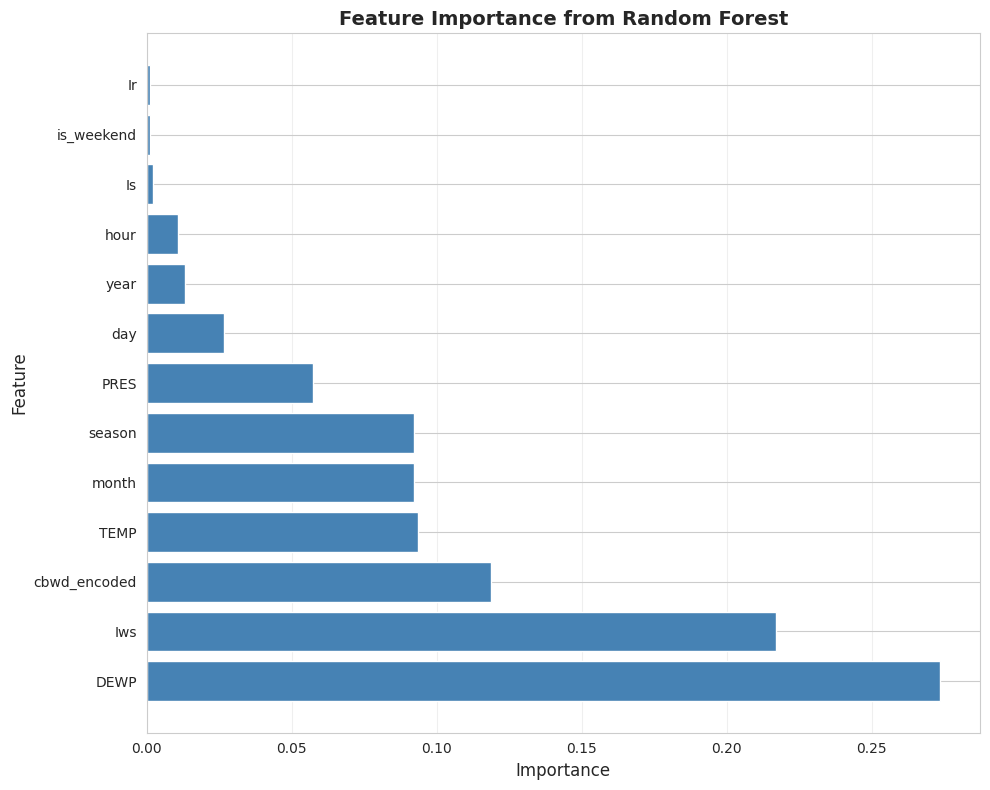


--------------------------------------------------------------------------------
Performing Recursive Feature Elimination (RFE)...
--------------------------------------------------------------------------------

 RFE completed

Selected features by RFE (top 8):
  1. year
  2. month
  3. day
  4. DEWP
  5. TEMP
  6. PRES
  7. Iws
  8. season


In [65]:
# 10. FEATURE SELECTION AND IMPORTANCE

print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Feature importance from best Random Forest
rf_importances = best_rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_importances
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (from Optimized Random Forest):")
print("-" * 80)
print(importance_df.to_string(index=False))

# Plot feature importance
print("\nGenerating feature importance plot...")
plt.figure(figsize=(10, 8))
plt.barh(range(len(importance_df)), importance_df['Importance'], color='steelblue')
plt.yticks(range(len(importance_df)), importance_df['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance from Random Forest', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print(" Saved: feature_importance.png")
plt.show()

# Recursive Feature Elimination (RFE)
print("\n" + "-" * 80)
print("Performing Recursive Feature Elimination (RFE)...")
print("-" * 80)

rfe_estimator = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfe_selector = RFE(estimator=rfe_estimator, n_features_to_select=8, step=1)
rfe_selector.fit(X_train_ml, y_train_ml)

selected_features = [feature_columns[i] for i in range(len(feature_columns)) if rfe_selector.support_[i]]

print(f"\n RFE completed")
print(f"\nSelected features by RFE (top {len(selected_features)}):")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i}. {feat}")

In [66]:
# 11. FINAL MODEL COMPARISON

print("\n" + "=" * 80)
print("FINAL MODEL COMPARISON")
print("=" * 80)

# Helper function to safely get a variable or NaN
def safe_var(var_name):
    return globals()[var_name] if var_name in globals() else np.nan

# Create list of models and metrics
model_metrics = [
    ('Neural Network', safe_var('test_mae_nn'), safe_var('test_rmse_nn'), safe_var('test_r2_nn')),
    ('Random Forest (Initial)', safe_var('test_mae_rf'), safe_var('test_rmse_rf'), safe_var('test_r2_rf')),
    ('Random Forest (Optimized)', safe_var('test_mae_rf_opt'), safe_var('test_rmse_rf_opt'), safe_var('test_r2_rf_opt')),
    ('Gradient Boosting (Initial)', safe_var('test_mae_gb'), safe_var('test_rmse_gb'), safe_var('test_r2_gb')),
    ('Gradient Boosting (Optimized)', safe_var('test_mae_gb_opt'), safe_var('test_rmse_gb_opt'), safe_var('test_r2_gb_opt'))
]

# Create DataFrame
results = pd.DataFrame(model_metrics, columns=['Model', 'Test MAE', 'Test RMSE', 'Test R²'])

# Round metrics for neat display
results[['Test MAE', 'Test RMSE', 'Test R²']] = results[['Test MAE', 'Test RMSE', 'Test R²']].round(4)

print("\n" + results.to_string(index=False))

# Save results
results.to_csv('model_comparison_results.csv', index=False)
print("\n Results saved to: model_comparison_results.csv")

# Identify best model based on Test R² (ignore NaN)
if results['Test R²'].notna().any():
    best_model_idx = results['Test R²'].idxmax()
    best_model_name = results.loc[best_model_idx, 'Model']
    best_r2 = results.loc[best_model_idx, 'Test R²']

    print("\n" + "=" * 80)
    print(f" BEST MODEL: {best_model_name}")
    print(f"   Test R²: {best_r2:.4f}")
    print("=" * 80)
else:
    print("\nNo valid R² metrics available to determine the best model.")


FINAL MODEL COMPARISON

                        Model  Test MAE  Test RMSE  Test R²
               Neural Network   36.9491    55.6196   0.6430
      Random Forest (Initial)   23.0323    38.9237   0.8281
    Random Forest (Optimized)   55.4977    78.0382   0.3089
  Gradient Boosting (Initial)   45.3541    66.0204   0.5053
Gradient Boosting (Optimized)       NaN        NaN      NaN

 Results saved to: model_comparison_results.csv

 BEST MODEL: Random Forest (Initial)
   Test R²: 0.8281


In [67]:
# 12. GENERATE FINAL SUMMARY

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)

print("\nGenerated Files:")
print("  1. PM25_distribution.png")
print("  2. PM25_temporal_trends.png")
print("  3. PM25_correlation_matrix.png")
print("  4. NN_training_history.png")
print("  5. NN_predicted_vs_actual.png")
print("  6. feature_importance.png")
print("  7. model_comparison_results.csv")

print("\nKey Findings:")
print(f"  • Dataset: {len(df_processed):,} samples with {len(feature_columns)} features")
print(f"  • Best Model: {best_model_name} (R² = {best_r2:.4f})")
print(f"  • Top 3 Features: {', '.join(importance_df.head(3)['Feature'].tolist())}")



ANALYSIS COMPLETE!

Generated Files:
  1. PM25_distribution.png
  2. PM25_temporal_trends.png
  3. PM25_correlation_matrix.png
  4. NN_training_history.png
  5. NN_predicted_vs_actual.png
  6. feature_importance.png
  7. model_comparison_results.csv

Key Findings:
  • Dataset: 41,757 samples with 13 features
  • Best Model: Random Forest (Initial) (R² = 0.8281)
  • Top 3 Features: DEWP, Iws, cbwd_encoded
